# Self-Driving Car Engineer Nanodegree
## Term 1, Project 4: **Advanced Lane Lines**
### Jupyter Notebook for Project: CarND-P4-ALL-StewartTeaze

In [5]:
# Import packages, setup associated shorthand names.
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Other imports brought from Project1;
# some may not be needed for P4... check as we go, remove extraneous before submission
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Utility Functions

In [288]:
# This function takes an image, object points, and image points;
# performs a camera calibration, image distortion correction; and 
# returns an undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# This function takes a color input image, converts it to gray scale,
# applies Sobel x or y, takes an absolute value and applies a threshold,
# then returns the binary output image.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output

# This function takes a color input image, converts it to gray scale,
# applies Sobel x or y, takes an absolute value and applies a threshold,
# then also creates a V-ColorChannel threshold image,
# then returns the stacked Gradient-Threshold & VColorChannel-Threshold binary output image.
def GradThresh_ColThresh_Stacked(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    return color_binary

# This function takes a color input image, converts it to gray scale,
# applies Sobel x or y, takes an absolute value and applies a threshold,
# then also creates a V-ColorChannel threshold image,
# then returns the combined Gradient-Threshold & VColorChannel-Threshold binary output image.
def GradThresh_ColThresh_Combined(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

# This is the Perspective Transform ("Warp") function
# which takes an image as input, uses four "source" coordinates on that image,
# and maps/transforms/warps the original image into a new image, based on four
# "destination" coordinates on the new image... then returns the "warped" image.
def warp(img):  
    # Define mapping coordinates of a trapezoid in source ("src") image
    src = np.float32(
        [[695, 454],
         [1054, 674],
         [256, 674],
         [584, 454]])
    
    # Define mapping coordinates of "warped" rectangle in destination ("dst") image
    dst = np.float32(
        [[1054, 0],
         [1054, 712],
         [256, 712],
         [256, 0]])
    
    # Compute the Perspective Trasform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform matrix Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

## Build up Camera Calibration Parameters, based on set of Camera Calibration images

In [48]:
images = glob.glob('camera_cal/calibration*.jpg') # Set up for processing "glob" of camera calibration images

# Initialize the camera calibration parameter data structures
imgpoints = []
objpoints = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Go thru the "glob" of camera calibration images,
# use OpenCV findChessboardCorners() to determine the corners,
# and save the values in the imgpoints() list
numFiles = 0; numProcessed = 0
for fname in images:
    numFiles += 1
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    if ret == True: # Some calibration images are not processable, only use those that are processable.
        numProcessed += 1
        imgpoints.append(corners)
        objpoints.append(objp)

print("Calibration Files - Number Processable/Total Number of Files:",str(numProcessed),"/",str(numFiles))

Calibration Files - Number Processable/Total Number of Files: 17 / 20


## Undistorted Calibration Image

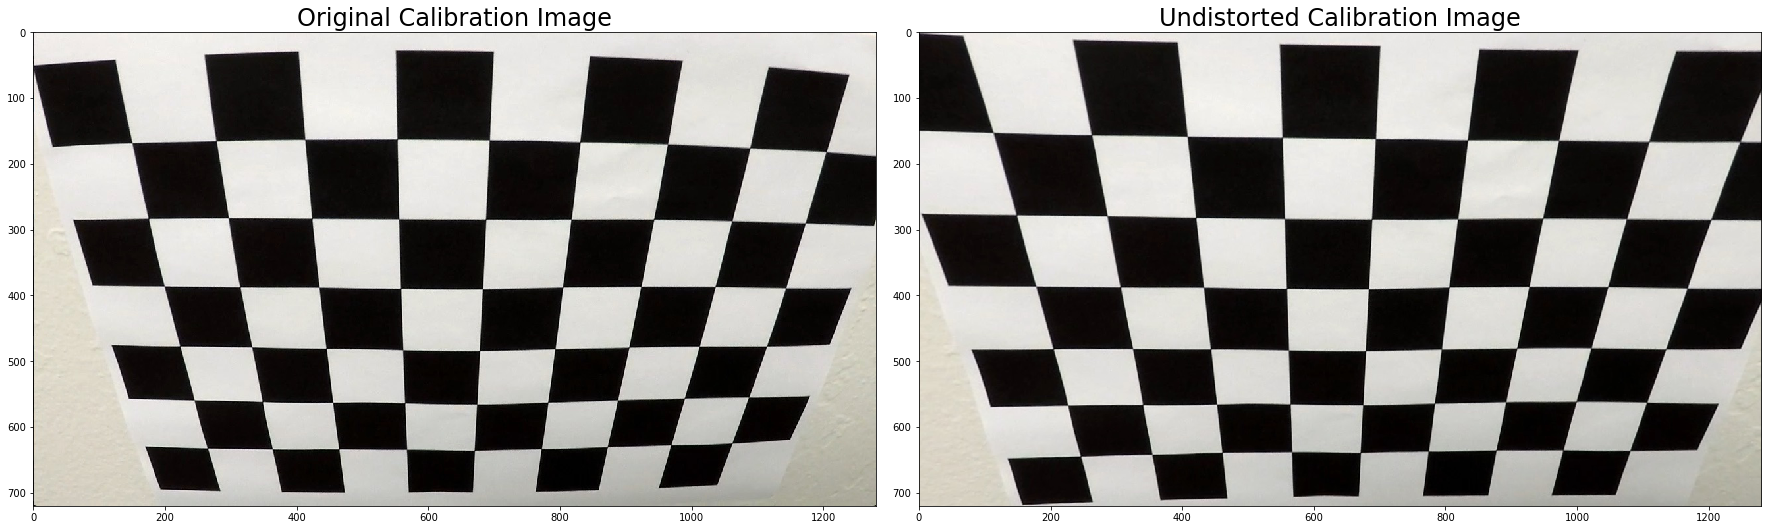

In [8]:
img = mpimg.imread('camera_cal/calibration2.jpg')  # Read in a sample calibration image

undistorted = cal_undistort(img, objpoints, imgpoints)  # undistort it

# Display original chessboard calibration image, and undistorted version of the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Calibration Image', fontsize=24)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Calibration Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistorted Test Image

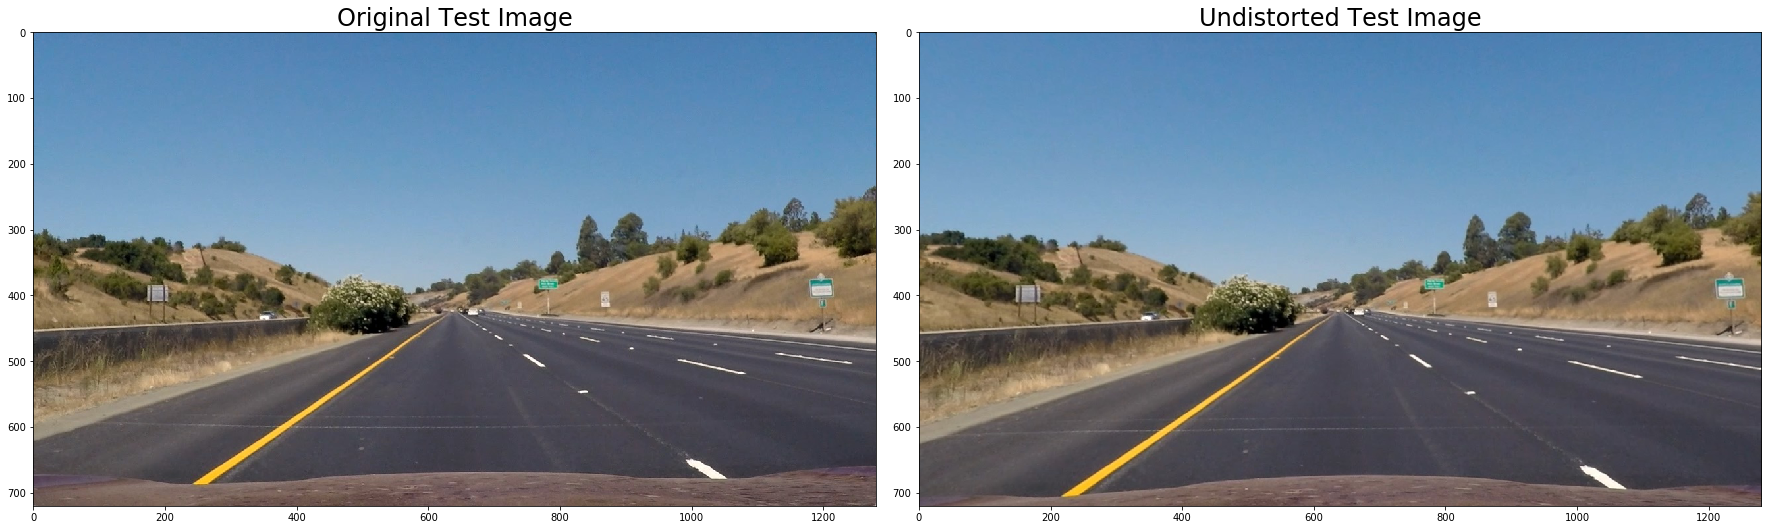

In [9]:
# img = mpimg.imread('test_images/test1.jpg')          # Read in a sample test image - slight curve example
img = mpimg.imread('test_images/straight_lines1.jpg')  # Read in a sample test image - straight lines example

undistorted = cal_undistort(img, objpoints, imgpoints)  # undistort it

# Display original test image, and undistorted version of the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Test Image', fontsize=24)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Test Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# cv2.imwrite('test_images/undist_straight_lines1.jpg', cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

## Gradiant-Thresholded Binary Image

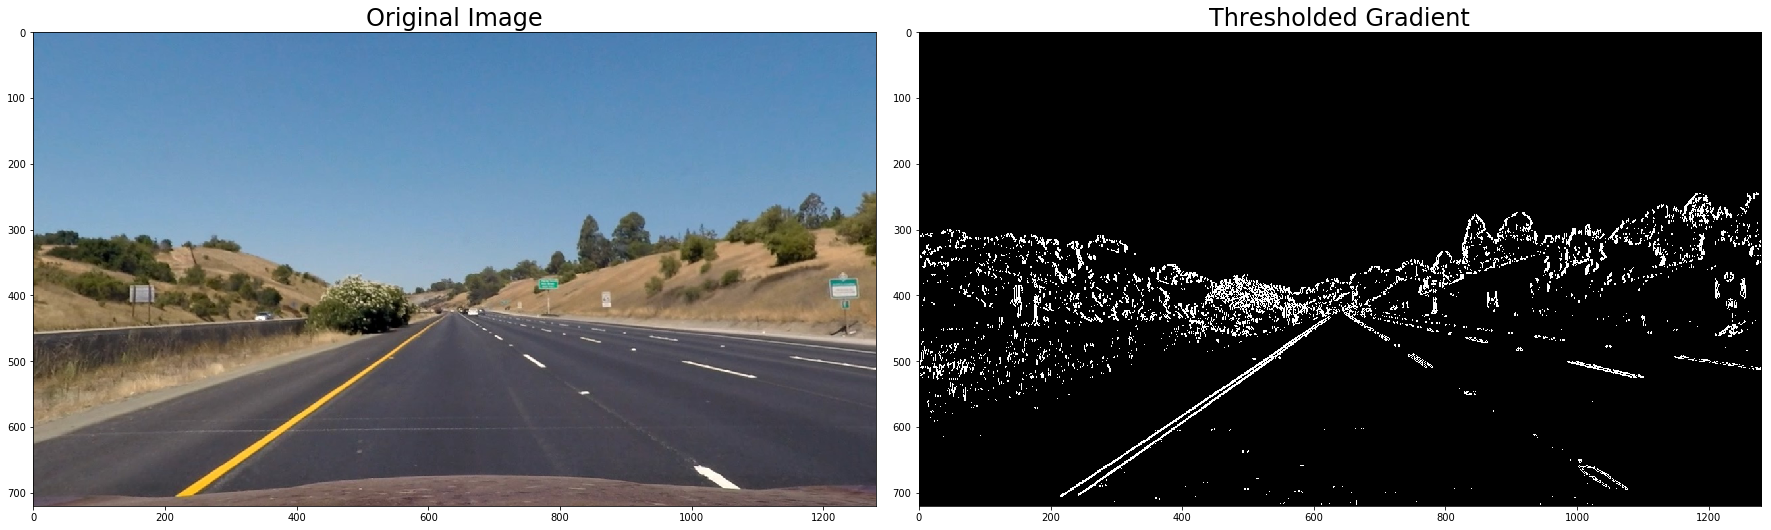

In [17]:
grad_binary = abs_sobel_thresh(undistorted, orient='x', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=24)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradiant-Thresholded/V-ColorChannel-Thresholded Stacked Binary Image

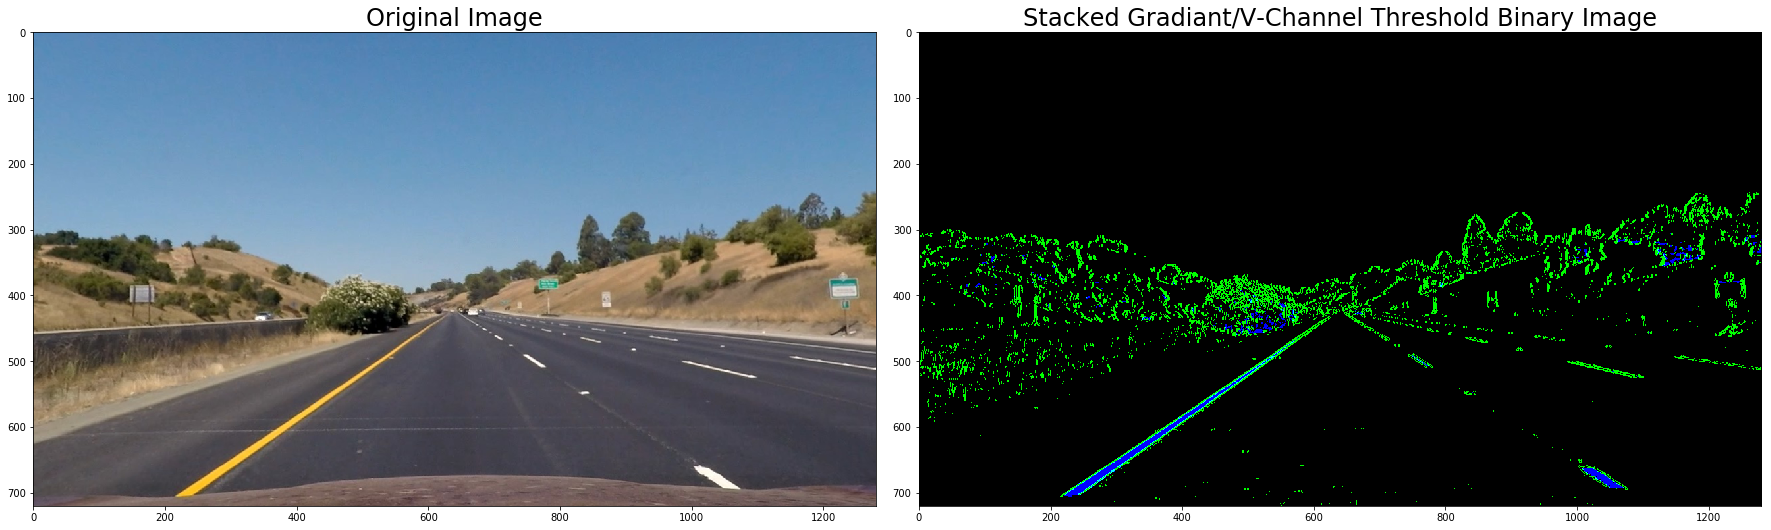

In [18]:
result = GradThresh_ColThresh_Stacked(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(result)
ax2.set_title('Stacked Gradiant/V-Channel Threshold Binary Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradiant-Thresholded/V-ColorChannel-Thresholded Combined Binary Image

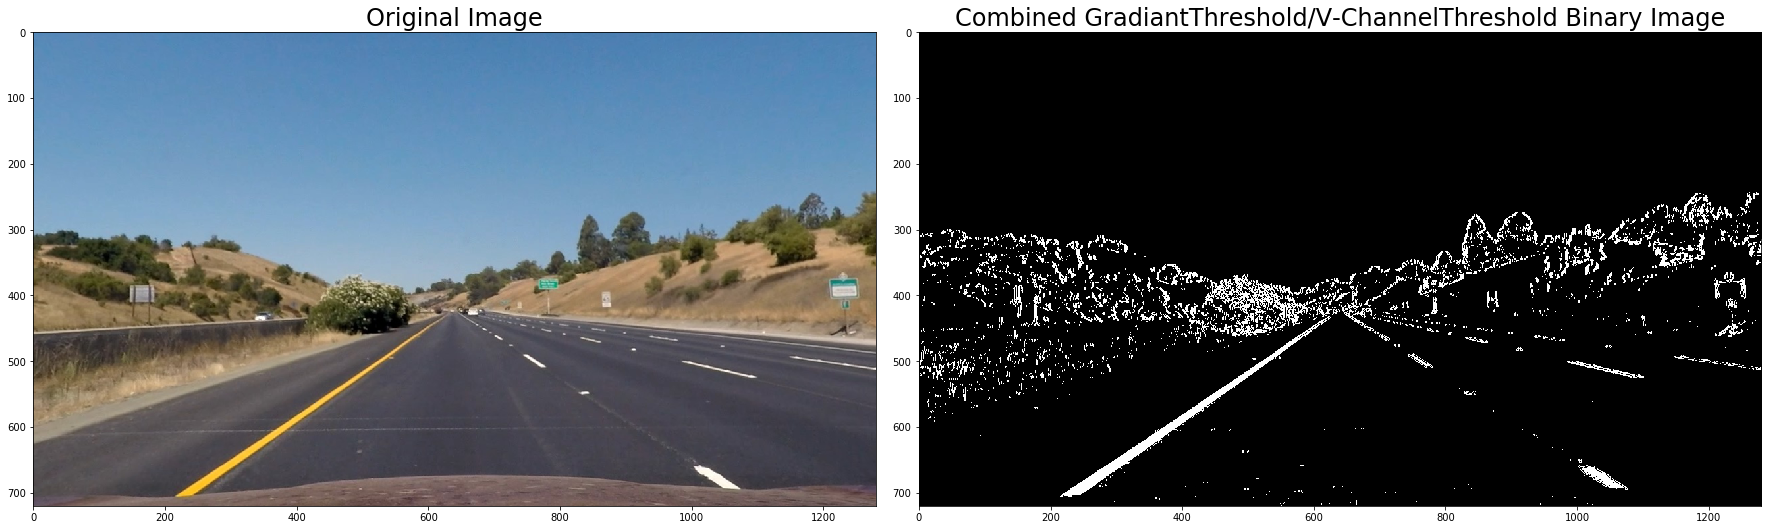

In [19]:
result = GradThresh_ColThresh_Combined(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(result, cmap='gray')
ax2.set_title('Combined GradiantThreshold/V-ChannelThreshold Binary Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Birds-Eye View Warped (Perspective Transformed) Image with Trapezoid -
### Trapezoid Corners show Source and Destination "Warp" Points

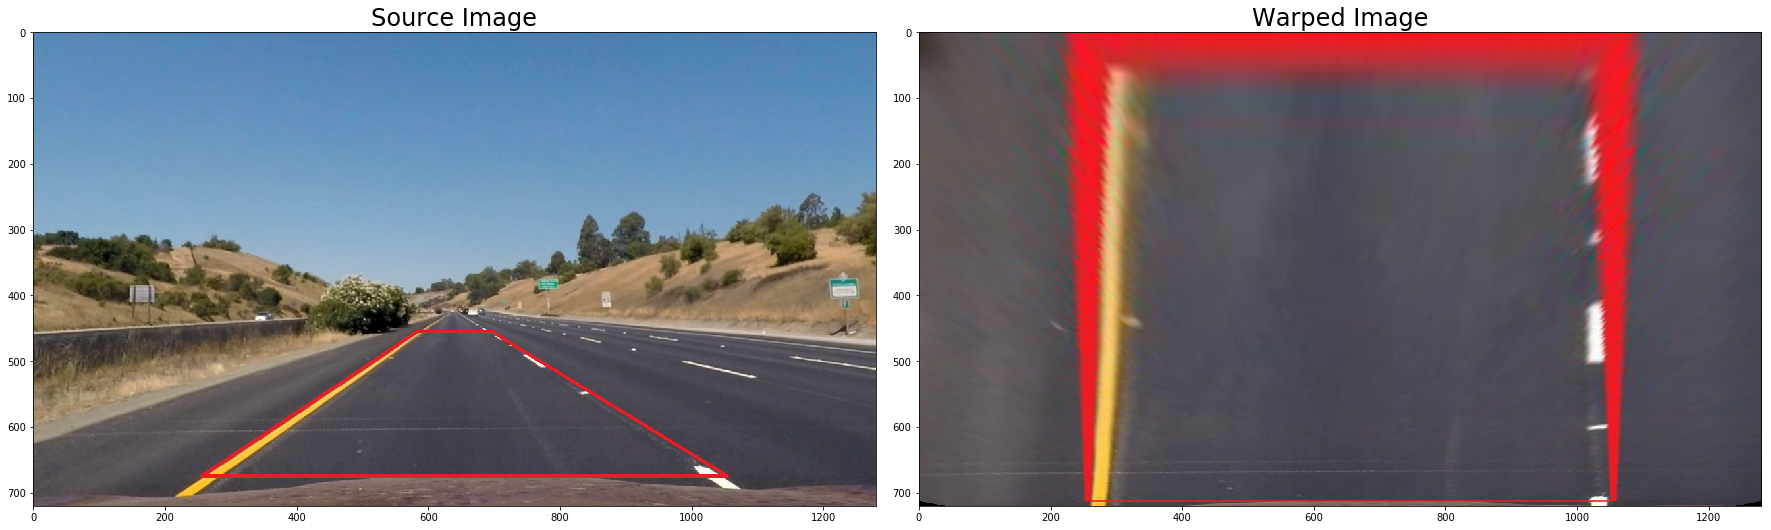

In [258]:
# Call "warp" Perspective Transform function to warp driver-view image into Birds-Eye View image.
undist_sl_trap = mpimg.imread('test_images/undist_straight_lines1_wTrapezoid.jpg')
warp_im = warp(undist_sl_trap)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Source Image', fontsize=24)
ax1.imshow(undist_sl_trap)
ax2.set_title('Warped Image', fontsize=24)
ax2.imshow(warp_im)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Birds-Eye View Warped (Perspective Transformed) Image

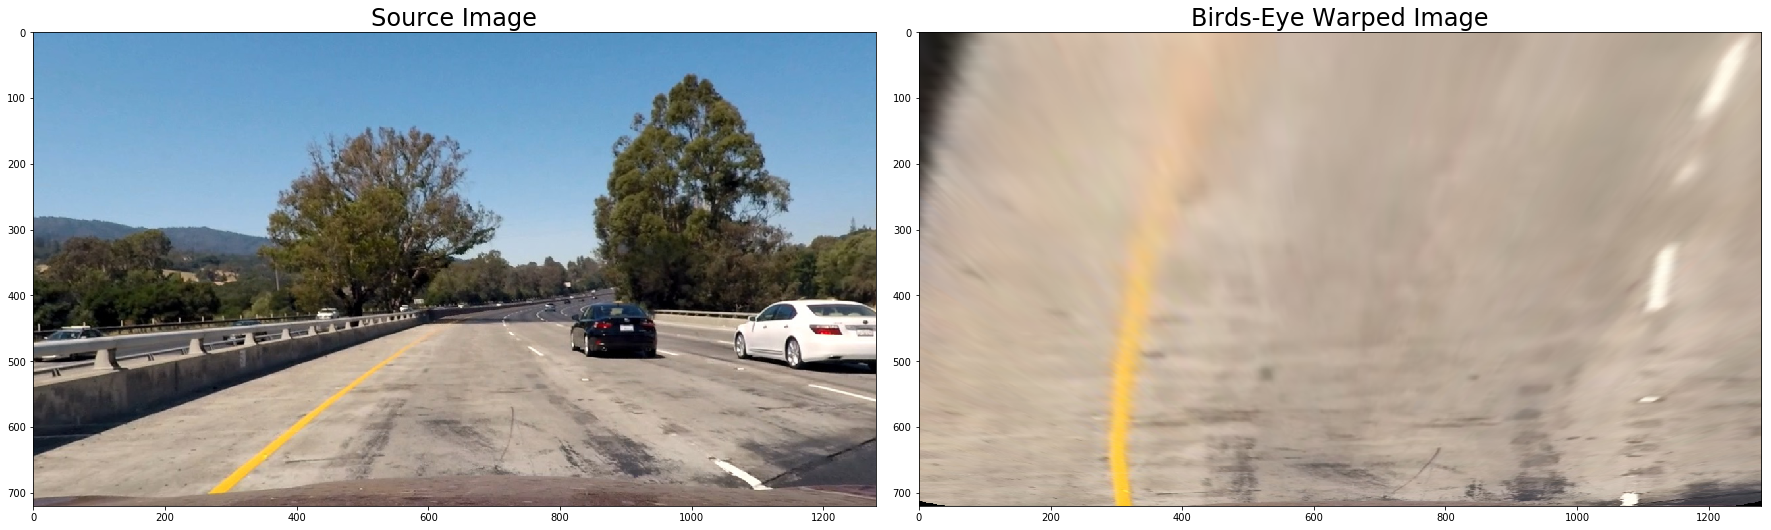

In [267]:
# Call "warp" Perspective Transform function to warp driver-view image into Birds-Eye View image.
warp_im = warp(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Source Image', fontsize=24)
ax1.imshow(undistorted)
ax2.set_title('Birds-Eye Warped Image', fontsize=24)
ax2.imshow(warp_im)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combined Gradiant-Thresholded/V-ColorChannel-Thresholded Birds-Eye Warped Image

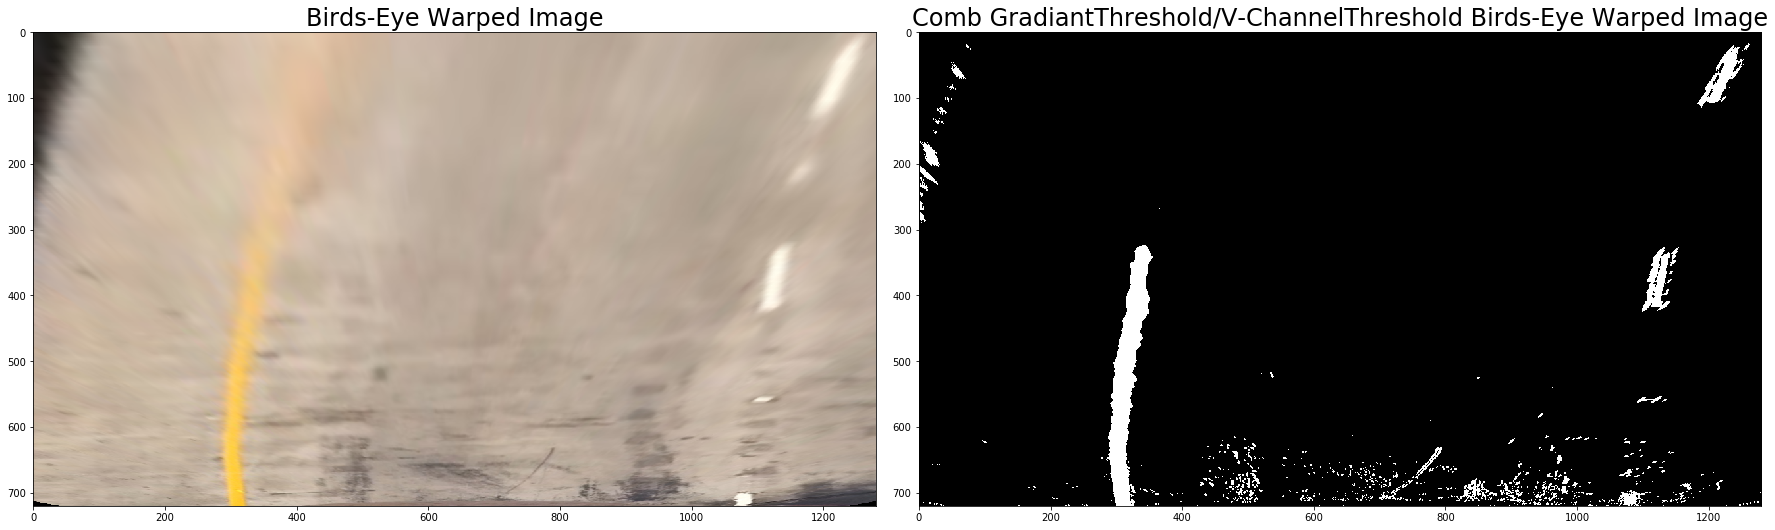

In [280]:
# Start working with "slight curve test image
img = mpimg.imread('test_images/test1.jpg')          # Read in a sample test image - slight curve example
undistorted = cal_undistort(img, objpoints, imgpoints)  # undistort it

# Call "warp" Perspective Transform function to warp driver-view image into Birds-Eye View image.
warp_im = warp(undistorted)

# CGTCTBEWimg = Combined GradiantThreshold/V-ChannelThreshold Birds-Eye Warped Image
CGTCTBEWimg = GradThresh_ColThresh_Combined(warp_im) 

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_im)
ax1.set_title('Birds-Eye Warped Image', fontsize=24)

ax2.imshow(CGTCTBEWimg, cmap='gray')
ax2.set_title('Comb GradiantThreshold/V-ChannelThreshold Birds-Eye Warped Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combined Gradiant-Threshold/V-ColorChannel-Threshold Birds-Eye Warped Image - Lower Half Histogram

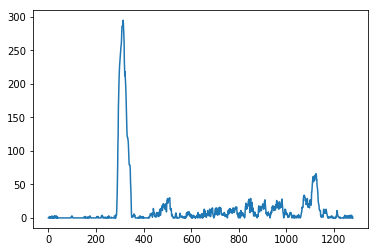

In [269]:
histogram = np.sum(CGTCTBEWimg[CGTCTBEWimg.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [270]:
# Take a histogram of the bottom half of the image
histogram = np.sum(CGTCTBEWimg[CGTCTBEWimg.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((CGTCTBEWimg, CGTCTBEWimg, CGTCTBEWimg))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(CGTCTBEWimg.shape[0]/nwindows+1)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = CGTCTBEWimg.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = CGTCTBEWimg.shape[0] - (window+1)*window_height
    win_y_high = CGTCTBEWimg.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

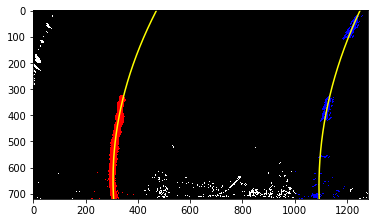

In [287]:
#
# GENERATE LEFT LANE and RIGHT LANE POLYNOMIAL-FITTED NUMPY ARRAYS 
#
# ploty is a 1D array of size 720 (which is the input image width/shape), and is initialized with values from 0-719.
#
# left_fitx and right_fitx are are 1D arrays also of size 720,
# with their indexed contents being the x value at each corresponded ploty() point.
#
ploty = np.linspace(0, CGTCTBEWimg.shape[0]-1, CGTCTBEWimg.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [272]:
nonzero = CGTCTBEWimg.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

#
# GENERATE LEFT LANE and RIGHT LANE POLYNOMIAL FITTED NUMPY ARRAYS 
#
# ploty is a 1D array of size 720 (which is the input image width/shape), and is initialized with values from 0-719.
#
# left_fitx and right_fitx are are 1D arrays also of size 720,
# with their indexed contents being the x value at each corresponded ploty() point.
#
ploty = np.linspace(0, CGTCTBEWimg.shape[0]-1, CGTCTBEWimg.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

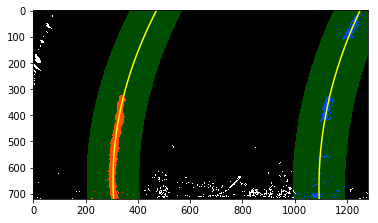

In [285]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((CGTCTBEWimg, CGTCTBEWimg, CGTCTBEWimg))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [273]:
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

412.996820591 m 470.656269087 m


## Birds-Eye Warped Image with lane lines

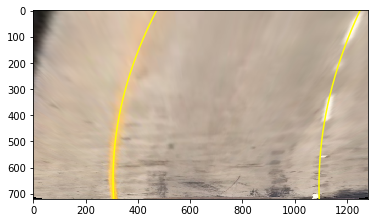

In [282]:
plt.imshow(warp_im)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

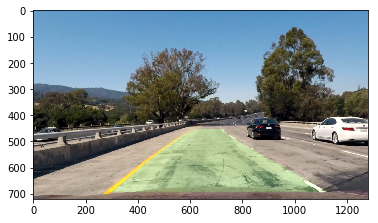

In [296]:
# Define mapping coordinates of a trapezoid in source ("src") image
src = np.float32(
    [[695, 454],
     [1054, 674],
     [256, 674],
     [584, 454]])
    
# Define mapping coordinates of "warped" rectangle in destination ("dst") image
dst = np.float32(
    [[1054, 0],
     [1054, 712],
     [256, 712],
     [256, 0]])
    
# Compute the inverse perspective transform matrix Minv
Minv = cv2.getPerspectiveTransform(dst, src)

# Create an image to draw the lines on
warp_zero = np.zeros_like(CGTCTBEWimg).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,128, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [297]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## process_image() lane-detection pipeline function

In [299]:
# The process_image() function contains the Lane Detection Pipeline
def process_image(img):
    """
    The input `img` is an image from a vehicle driver-view camera; either a still image, or video frame image.
    
    The returned result is an image with highlighted lane lines overlayed on the input image.
    """
    # undistort the input image using the pre-initialized camera calibration parameter data structures,
    # using the cal_undistort() utility function.
    undistorted = cal_undistort(img, objpoints, imgpoints)  

    # Call the "warp" Perspective Transform utility function to warp driver-view image into Birds-Eye View image.
    warp_im = warp(undistorted)

    # CGTCTBEWimg = Combined GradiantThreshold/V-ChannelThreshold Birds-Eye Warped Image
    CGTCTBEWimg = GradThresh_ColThresh_Combined(warp_im) 

    # 
    # FIRST PASS, OR RE-SYNCHRONIZATION PROCESSING... need to add alternative processing if already sync'd
    #
    # Take a histogram of the bottom half of the image
    histogram = np.sum(CGTCTBEWimg[CGTCTBEWimg.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((CGTCTBEWimg, CGTCTBEWimg, CGTCTBEWimg))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(CGTCTBEWimg.shape[0]/nwindows+1)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = CGTCTBEWimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = CGTCTBEWimg.shape[0] - (window+1)*window_height
        win_y_high = CGTCTBEWimg.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #
    # GENERATE LEFT LANE and RIGHT LANE POLYNOMIAL-FITTED NUMPY ARRAYS 
    #
    # ploty is a 1D array of size 720 (which is the input image width/shape), and is initialized with values from 0-719.
    #
    # left_fitx and right_fitx are are 1D arrays also of size 720,
    # with their indexed contents being the x value at each corresponded ploty() point.
    #
    ploty = np.linspace(0, CGTCTBEWimg.shape[0]-1, CGTCTBEWimg.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # UNWARP PROCESSING - MAKE THIS A unwarp() UTILITY FUNCTION EVENTUALLY
    # Define mapping coordinates of a trapezoid in source ("src") image
    src = np.float32(
        [[695, 454],
         [1054, 674],
         [256, 674],
         [584, 454]])

    # Define mapping coordinates of "warped" rectangle in destination ("dst") image
    dst = np.float32(
        [[1054, 0],
         [1054, 712],
         [256, 712],
         [256, 0]])
    
    # Compute the inverse perspective transform matrix Minv
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(CGTCTBEWimg).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,128, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result

## process_image pipeline function Test Images

In [301]:
# Perform tests of the process_image pipeline function,
# using all images from the test_images directory,
# saving all output files to the test_images_output directory;
# as instructed in the Test Images & Build a Lane Finding Pipeline sections
# of the CarND-LaneLines-P1-master/P1.ipynb file.
image = mpimg.imread('test_images/test1.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/test1.jpg',final_img)
image = mpimg.imread('test_images/test2.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/test2.jpg',final_img)
image = mpimg.imread('test_images/test3.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/test3.jpg',final_img)
image = mpimg.imread('test_images/test4.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/test4.jpg',final_img)
image = mpimg.imread('test_images/test5.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/test5.jpg',final_img)
image = mpimg.imread('test_images/test6.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/test6.jpg',final_img)
image = mpimg.imread('test_images/straight_lines1.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/straight_lines1.jpg',final_img)
image = mpimg.imread('test_images/straight_lines2.jpg')
final_img = process_image(image)
mpimg.imsave('test_images_output/straight_lines2.jpg',final_img)

## process_image pipeline function Video Tests

In [304]:
# Test process_image() pipeline funstion against project_video.mp4 video input file;
# and write out the resulting video file, with lane lines overlayed, to 'test_videos_output' directory.
lane_output = 'test_videos_output/project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image)
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_out.mp4
[MoviePy] Writing video test_videos_output/project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:12<00:00,  1.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_out.mp4 

Wall time: 15min 12s


In [305]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_output))

In [ ]:
# Now test process_image with solidWhiteRight.mp4 video input file;
# and write out the resulting video file to 'test_videos_output' directory
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))